<center><font size = "10"> Multicompartmental Neuron Model: <center>
<center><font size = "8"> Cable Theory <center>
<center><font size = "8">Tutorial 01: Passive Properties<center>

<font size='3'><font color='blue'>During this tutorial you will study voltage spatial attenuation on simple morphologies with only passive membrane properties using the approach of the cable theory shown during the lecture.
    
<font size='3'><font color='blue'>In order to understand what is going on along this tutorial, you should review the concepts of __cable theory__ in the lecture and/or in [here](https://en.wikipedia.org/wiki/Cable_theory) as well as the concept of __passive electrical properties__ of a neuron in [here](http://www.scholarpedia.org/article/Neuron#:~:text=themes%20of%20concern.-,Passive%20electrical%20properties,cytoplasm%20and%20the%20extracellular%20milieu.)

# 1. Voltage spatial discretization

In [1]:
# First call all the useful packages
%matplotlib inline
from neuron import h
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
# Create a section
soma = h.Section()
soma.Ra = 1
soma.L = 100
soma.diam = 10
soma.cm = 1

# Inject a current step into the soma
stim = h.IClamp(soma(0.5))  # Place a stimulation electrode in the middle of the soma
stim.delay = 1  # ms
stim.amp = 1  # pA
stim.dur = 3  # ms

# Initialize NEURON vectors to record time, voltage and current
rec_t = h.Vector()
rec_t.record(h._ref_t)

rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)

rec_i = h.Vector()
rec_i.record(stim._ref_i)

# Initialize and run a simulation
h.load_file("stdrun.hoc")
h.finitialize(-65)
h.continuerun(5)
h.steps_per_ms = 40.0

h.init()
h.run()

0.0

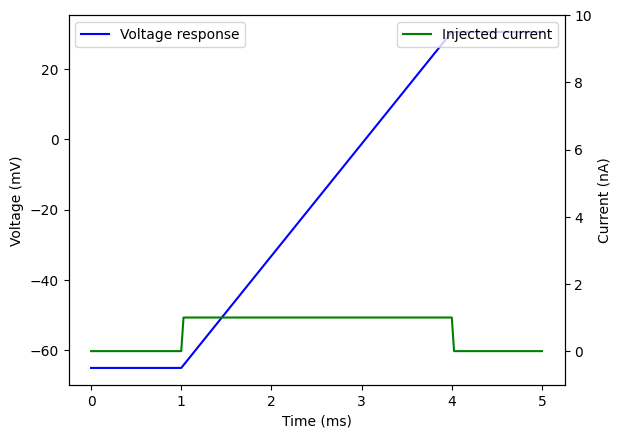

In [3]:
# Plot the stimulation protocol and the voltage response
fig, ax1 = plt.subplots()
plt.plot(rec_t, rec_v, "b", label="Voltage response")
ax2 = ax1.twinx()
plt.plot(rec_t, rec_i, "g", label="Injected current")

ax2.set_ylim([-1, 10])
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Voltage (mV)")
ax2.set_ylabel("Current (nA)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right");

<font size="3">In the previous simulation we recorded the voltage response at the middle of the soma. 

<font size="3">To have more refined spatial discretization we can increase *nseg*. To make sure that the electrodes have the best accuracy, it is always advisable to have an odd number of segments. However, we always have to record through time from the center of each compartment, then "transpose" the recordings to visualize the results across space.

In [4]:
soma.nseg = 11


def transpose_recording(reclist, nloc, tstop):
    retlist = []
    # each element of reclist is a neuron.h.Vector of recordings for one out of nloc spatial locations
    # (usually compartment centers) over time
    for i in range(0, int(tstop / h.dt) + 1):
        retlist.append(h.Vector(nloc, 0))
        for j in range(0, nloc):
            retlist[i].x[j] = reclist[j].x[i]

    return retlist

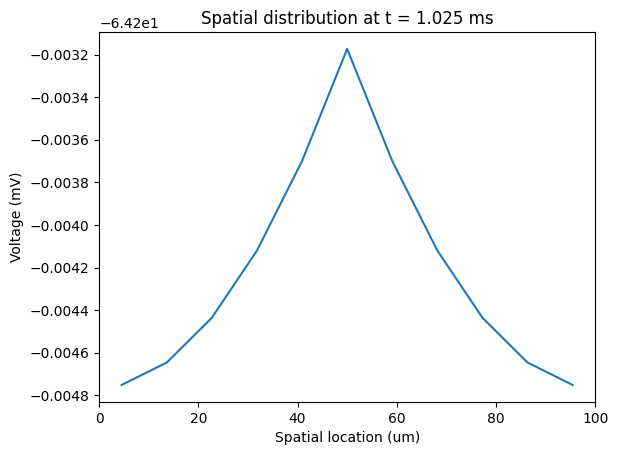

In [5]:
reclist = h.List()

for i in range(0, soma.nseg):
    tmpRecVec = h.Vector()
    tmpRecVec.record(soma((0.5 + i * 1.0) / soma.nseg)._ref_v)
    reclist.append(tmpRecVec)

h.init()
h.run(11)
xlocations = h.Vector()

for i in range(0, soma.nseg):
    xlocations.append(soma.L * (0.5 + i * 1.0) / (soma.nseg))

spatialrec = transpose_recording(reclist, soma.nseg, 5)
fig = plt.figure()
plt.plot(xlocations, spatialrec[41])  # 1.025/0.025 = 41
plt.ylabel("Voltage (mV)")
plt.xlabel("Spatial location (um)")
plt.title("Spatial distribution at t = 1.025 ms");

# 2. Voltage spatial attenuation: more complex morphologies

<font color='red'><font size='5'>RESTART YOUR KERNEL

In [1]:
# First call all the usefull packages
%matplotlib inline

from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import view
from hoc2swc import neuron2swc

--No graphics will be displayed.


In [2]:
# Defining some usefull functions.

# Global containers for objects
simulations_records = []  # stimulations
voltage_records = []  # voltage recordings
current_records = []  # current recordings


def reset():
    """Convenience functions for setting up stimulation, recording and simulation"""
    del simulations_records[:]
    del voltage_records[:]
    del current_records[:]


def iclamp(location, delay=100, amplitude=0.1, duration=500):
    """"Inject a current step with parameters at location"""
    stim = h.IClamp(location)  # Place a stimulation electrode at location
    stim.delay = delay  # stim delay (ms)
    stim.amp = amplitude  # stim amplitude (pA)
    stim.dur = duration  # stim duration (ms)
    simulations_records.append({"stim": stim, "loc": str(location)})


def record_voltage(location):
    """Setup recording of voltage at location"""
    vec = h.Vector()
    vec.record(location._ref_v)  # record voltage at location
    voltage_records.append({"vec": vec, "loc": str(location)})


def record_current(stimulation_dict):
    """Setup recording of stimulation current"""
    vec = h.Vector()
    vec.record(stimulation_dict["stim"]._ref_i)  # record stimulation current
    current_records.append({"vec": vec, "loc": stimulation_dict["loc"]})


def init_run(v_i, t_stop):
    """Initialize and run a simulation"""
    # Record time
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # Record current for all stimuli
    for stimulation_dict in simulations_records:
        record_current(stimulation_dict)
    # Setup simulation and run
    h.load_file("stdrun.hoc")
    h.finitialize(v_i)  # initial voltage
    h.continuerun(t_stop)  # final time
    return rec_t


def tvi_plots(t, voltage_records=[], current_records=[], vmax=40, imax=0.5):
    """Plot current and voltage for all stims and recordings"""
    plt.figure()
    plt.title("currents")
    plt.ylim((-0.01, imax))
    plt.xlabel("t (ms)")
    plt.ylabel("I (pA)")
    for idict in current_records:
        plt.plot(t, idict["vec"], label=idict["loc"])
    plt.legend(loc=1)

    plt.figure()
    plt.title("voltages")
    plt.ylim((-71, vmax))
    plt.ylabel("V (mV)")
    plt.xlabel("t (ms)")
    for vdict in voltage_records:
        plt.plot(t, vdict["vec"], label=vdict["loc"])
    plt.legend(loc=1)


def plot_morphology(fname="cell_01"):
    fname = "{}.swc".format(fname)
    h.define_shape()
    h.topology()
    neuron2swc(fname, swap_yz=False)
    neuron1 = nm.load_morphology(fname)
    view.plot_morph(neuron1)

<font size='3'>Create a morphology with soma, dendrite and axon


|-|       soma(0-1)
   `----|       dend(0-1)
 `----|       axon(0-1)

Wrote cell 0 to cell_02.swc


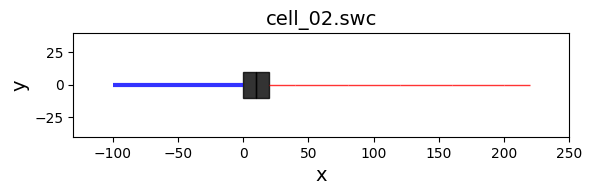

In [3]:
# Define all the sections first
soma = h.Section(name="soma")
dend = h.Section(name="dend")
axon = h.Section(name="axon")

# Soma section (black in plot)
soma.L = 20  # length (µm)
soma.diam = 20  # diameter (µm)
soma.Ra = 123.0  # axial resistivity (Ω*cm)
soma.cm = 1  # capacitance (µF/cm^2)

# Dendrite section (red in plot)
dend.L = 200  # length (µm)
dend.diam = 1  # diameter (µm)
dend.nseg = 5  # number of segments
dend.Ra = 123.0  # axial resistivity (Ω*cm)
dend.cm = 1  # capacitance (µF/cm^2)

# Axon section (blue in plot)
axon.diam = 3
axon.L = 100  # length (µm)
axon.nseg = 5  # diameter (µm)
axon.Ra = 123.0  # axial resistivity (Ω*cm)
axon.cm = 1  # capacitance (µF/cm^2)

# Topology
dend.connect(soma(1))
axon.connect(soma(0))

# Passive properties
soma.insert("pas")
for seg in soma:
    seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
    seg.pas.e = (
        -70
    )  # Leak reversal potential, it influences the steady state membrane potential

dend.insert("pas")
for seg in dend:
    seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
    seg.pas.e = (
        -70
    )  # Leak reversal potential, it influences the steady state membrane potential

axon.insert("pas")
for seg in axon:
    seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
    seg.pas.e = (
        -70
    )  # Leak reversal potential, it influences the steady state membrane potential

# Plot morphology so far
plot_morphology("cell_02")

<font size='3'>Let's stimulate at the far end of the dendrite and record in the soma

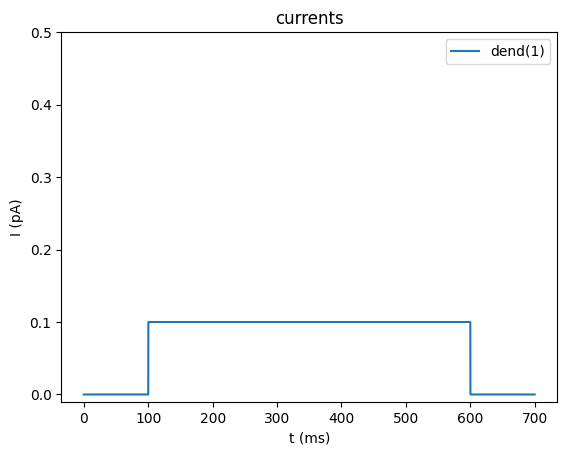

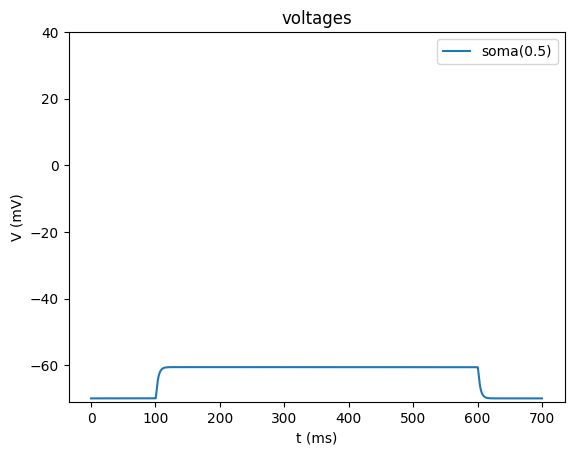

In [4]:
reset()

# Setup stimulations and recordings
iclamp(dend(1), amplitude=0.1)
record_voltage(soma(0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records)

<font size='3'>Let's do it again but with a higher current. Note how the voltage at the soma is higher.

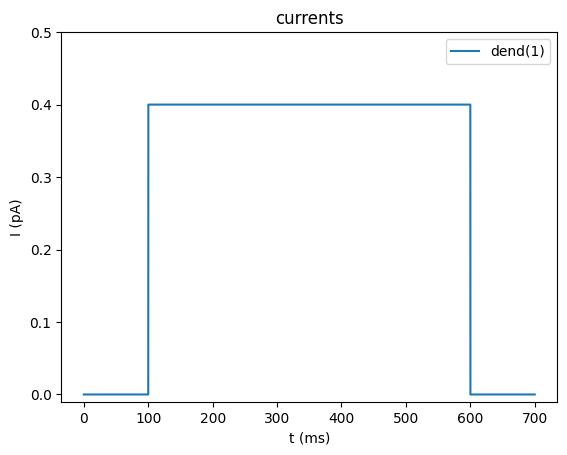

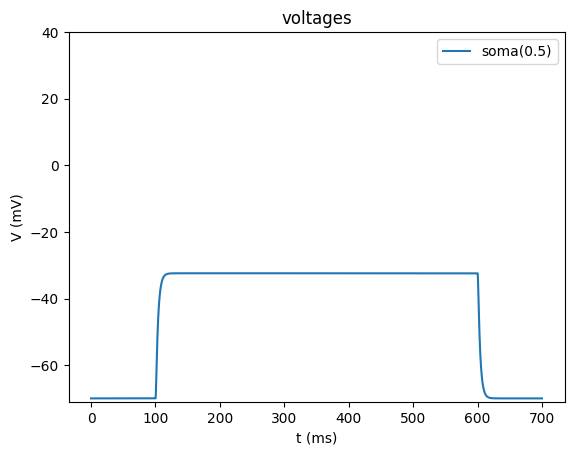

In [5]:
reset()

# Setup stimulations and recordings
iclamp(dend(1), amplitude=0.4)
record_voltage(soma(0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records)

<font size='3'>Let's try again but stimulating at different locations along the dendrite at different times. Note how the voltage recorded at the soma has diminishing amplitude as we stimulate farther along the dendrite.

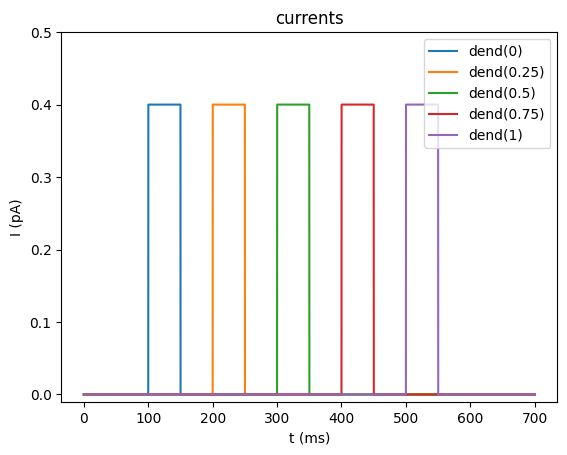

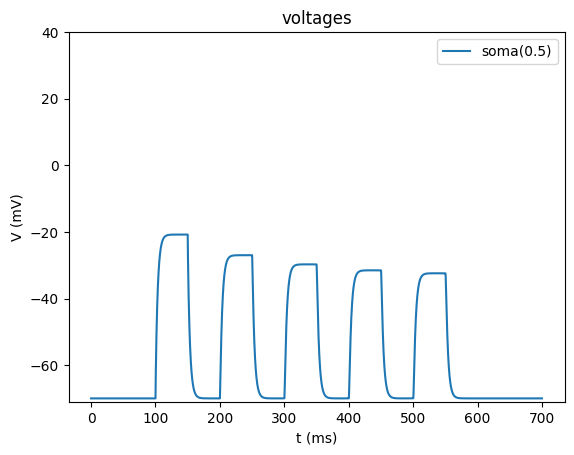

In [6]:
reset()

# Scan at different locations with different delays
delays = np.arange(100, 600, 100)
locations = np.linspace(0, 1, 5)

# Setup stimulations and recordings
for p in zip(locations, delays):
    iclamp(dend(p[0]), amplitude=0.4, delay=p[1], duration=50)
record_voltage(soma(0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records)

<font size='3'>The same, but this duplicating the diameter of the dendrite. 

<font size='3'>Note how the amplitudes at the soma get reduced. This is because a larger diameter means a lower membrane resistance which leads to a smaller length constant.

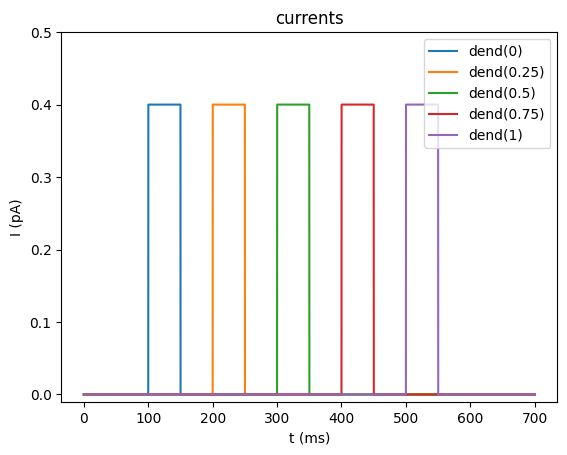

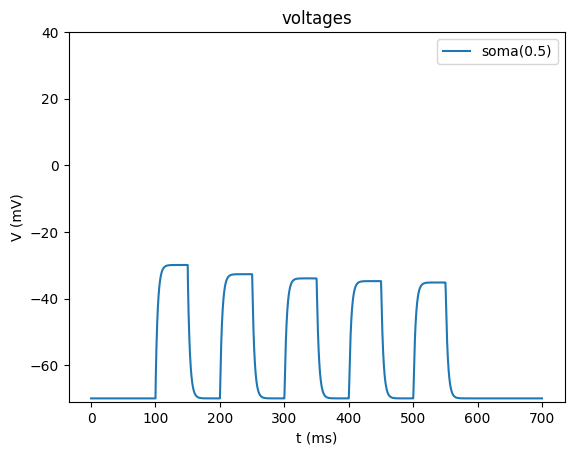

In [7]:
reset()

# Duplicate dendrite diameter
dend.diam = 2

# Scan at different locations with different delays
delays = np.arange(100, 600, 100)
locations = np.linspace(0, 1, 5)

# Setup stimulations and recordings
for p in zip(locations, delays):
    iclamp(dend(p[0]), amplitude=0.4, delay=p[1], duration=50)
record_voltage(soma(0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records)

<font size='3'>Now let's stimulate once at the soma and measure at different locations along the dendrite. We can observe attenuation.

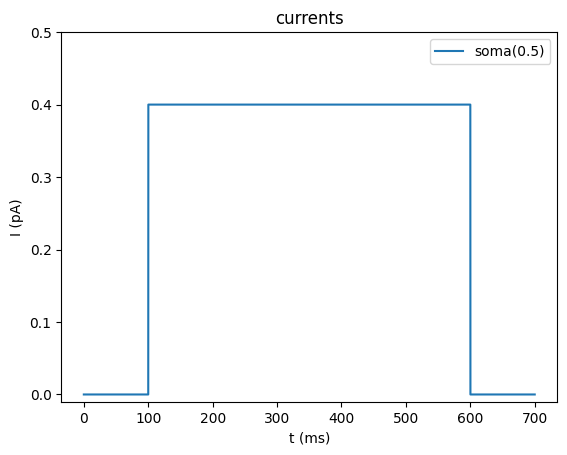

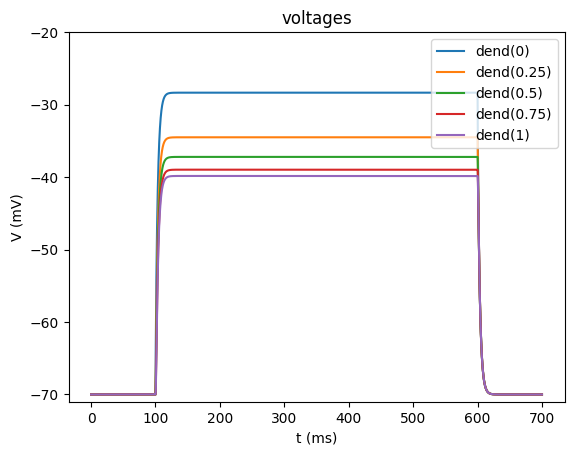

In [8]:
reset()

# Increase axial resistivity
dend.Ra = 300

# Scan at different locations with different delays
locations = np.linspace(0, 1, 5)

# Setup stimulations and recordings
iclamp(soma(0.5), amplitude=0.4)
for p in locations:
    record_voltage(dend(p))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records, vmax=-20)

<font size='3'>Now let's add four branches to the dendritic tree, with different dimensions (exagerated).


|-|       soma(0-1)
   `----|       dend(0-1)
         `|       branch_0(0-1)
         `|       branch_1(0-1)
         `|       branch_2(0-1)
         `|       branch_3(0-1)
 `----|       axon(0-1)

Wrote cell 0 to cell_03.swc


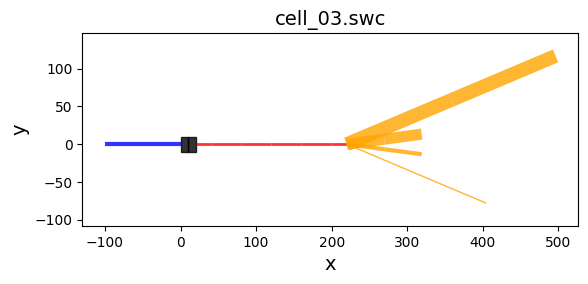

In [9]:
branch_0 = h.Section(name="branch_0")
branch_1 = h.Section(name="branch_1")
branch_2 = h.Section(name="branch_2")
branch_3 = h.Section(name="branch_3")

branchlst = [branch_0, branch_1, branch_2, branch_3]

# Branch geometry
# Long and thick
branch_0.L = 300
branch_0.diam = 10
# Short and thin
branch_1.L = 100
branch_1.diam = 8
# Short and thick
branch_2.L = 100
branch_2.diam = 3
# Long and thin
branch_3.L = 200
branch_3.diam = 1

# Connect them
branch_0.connect(dend(1))
branch_1.connect(dend(1))
branch_2.connect(dend(1))
branch_3.connect(dend(1))

# Passive properties in dendrite branches
for branch in branchlst:
    branch.Ra = 130.0  # axial resistivity (Ω*cm)
    branch.cm = 1  # capacitance (µF/cm^2)
    branch.insert("pas")
    for seg in branch:
        seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
        seg.pas.e = (
            -70
        )  # Leak reversal potential, it influences the steady state membrane potential

plot_morphology("cell_03")

<font size='3'>Now let's stimulate the different branches and measure at the soma. Note the different amplitude of responses.

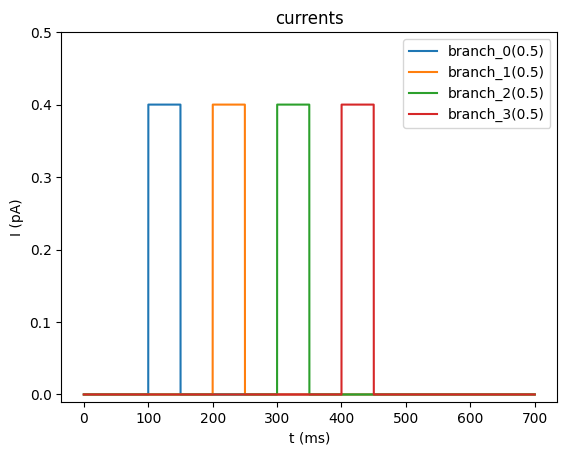

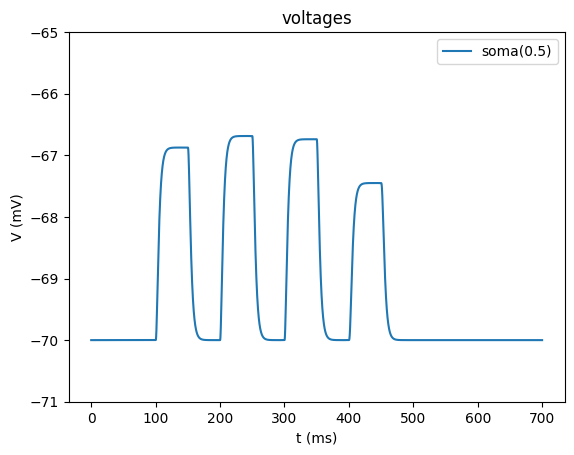

In [10]:
reset()

# Setup stimulations and recordings
for idx, branch in enumerate(branchlst):
    iclamp(branch(0.5), amplitude=0.4, delay=100 + idx * 100, duration=50)
record_voltage(soma(0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records, vmax=-65)

<font size='3'>Now let's do the reverse. Stimulate at the soma and measure at the distal ends of branches.

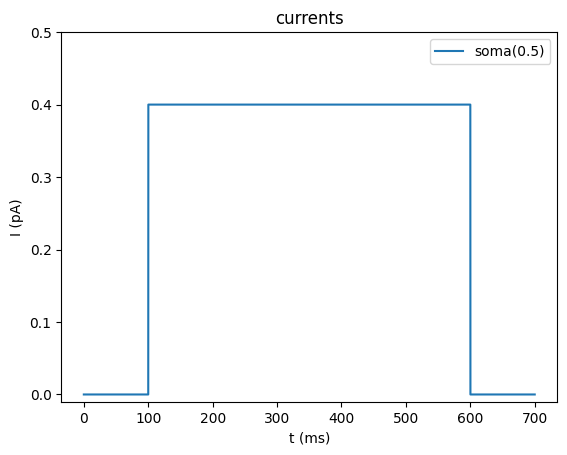

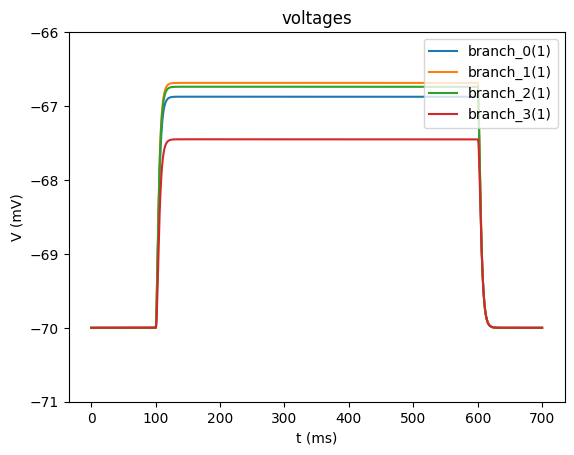

In [11]:
reset()

# Setup stimulations and recordings
iclamp(soma(0.5), amplitude=0.4)
for branch in branchlst:
    record_voltage(branch(1))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records, vmax=-66)